In [1]:
from functools import partial
from fractions import Fraction

import numpy as np
from scipy.special import p_roots

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

## Exercise 4 {-}

We begin by defining the function $f$ we want to integrate over.

In [2]:
def f(y):
    if not isinstance(y,list):
        y = [y]
    
    s = len(y)
    res = np.power(2 + 1/(2.*s), s)
    
    for yj in y:
        res *= np.power(yj, 1 + 1/(2.*s))
        
    return res

Next, we implement the one-dimensional trapezoidal rule. 

In [3]:
def trapezoidal1d(f, a, b, N):
    
    ys = np.linspace(a,b,N)
    ys = ys[1:-1]
    h = ys[1] - ys[0]
    
    res = (f(a) + f(b))/2.
    for y in ys:
        res += f(y)
        
    return h*res

Using this rule, we can implement the product trapezoidal rule for arbitrary dimensions using a recursive approach.

In [4]:
class MultiDQuadrature:
    def __init__(self,rule1d, f, a, b, N):
        self.rule1d = rule1d
        self.f = f
        self.a = a
        self.b = b
        self.N = N
        self.maxdepth = len(a)
    
    def integrate(self,*args, **kwargs):
        depth = kwargs.pop('depth', 0)
        
        if depth == self.maxdepth - 1:
            func = self.f
        else:
            func = partial(self.integrate, depth=depth+1)
            
        res = self.rule1d(func, self.a[depth], self.b[depth], self.N)

        return res
    

Below, we plot the quadrature error against the total number of evaluation points for different dimensions.

We can clearly observe the curse of dimensionality since the quadrature error is of the order
$$
\mathcal{O}(N^{-2/d})\,,
$$
where $d$ is the dimension and $N$ is the number of total evaluations (the factor $2$ comes from the fact that the trapezoidal rule is of order $2$ in 1D).

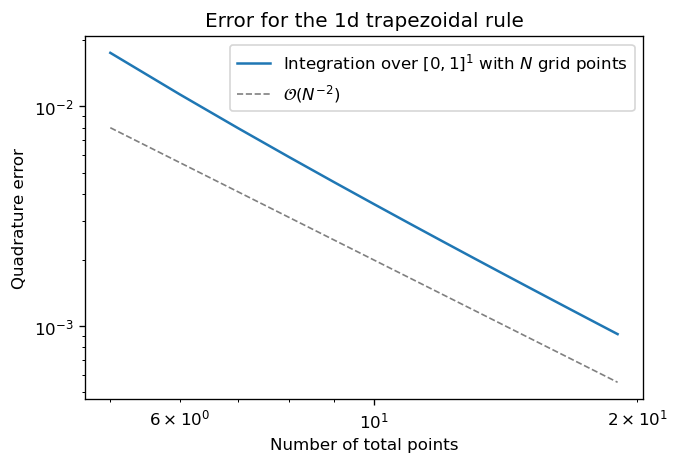

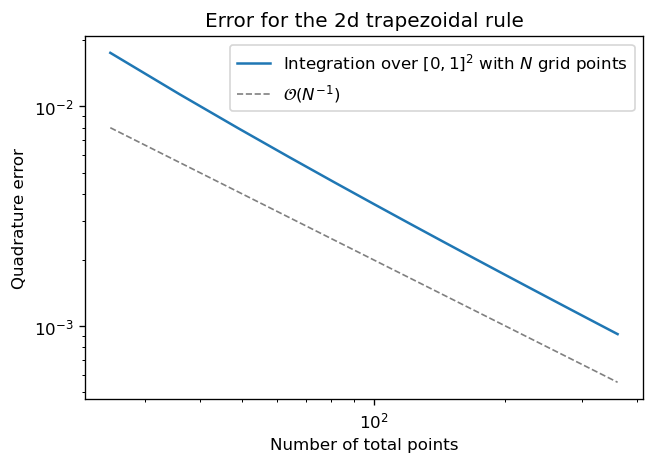

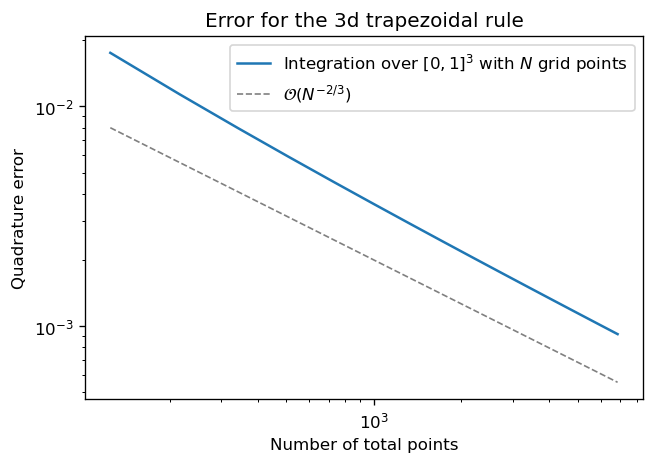

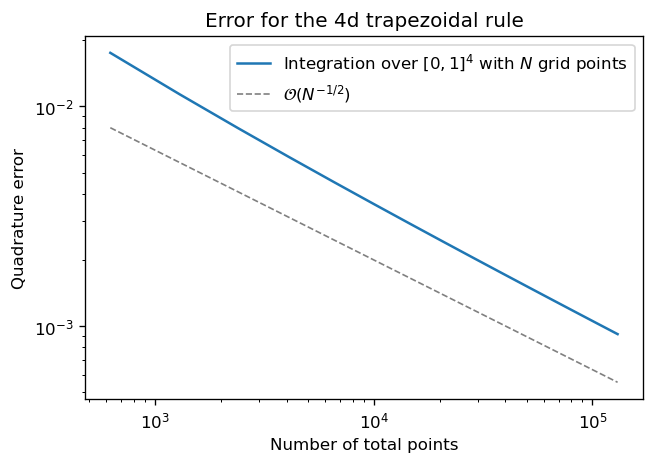

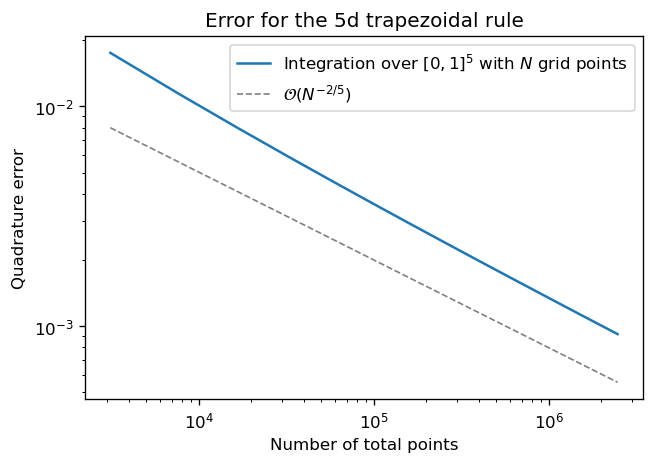

In [5]:
dimensions = [1,2,3,4,5]

for dim in dimensions:
    Ns = np.arange(5,20)
    
    a = np.zeros((dim,))
    b = np.ones((dim,))
    
    res = np.array([MultiDQuadrature(trapezoidal1d,f,a,b,N).integrate() for N in Ns])
    
    error = np.abs(res - 1.)
    
    plt.loglog(np.array(Ns)**dim, error, label=f"Integration over $[0,1]^{dim}$ with $N$ grid points")

    # Plot convergence order
    x0 = Ns[0]**dim
    x1 = Ns[-1]**dim
    y = lambda x : 0.2/x**(2/dim)
    y0 = y(x0)
    y1 = y(x1)
    
    order = Fraction(2,dim)

    plt.loglog([x0,x1], [y0,y1], '--', color='gray', label=f"$\mathcal{{O}}(N^{{-{order}}})$", linewidth=1)

    plt.ylabel('Quadrature error')
    plt.xlabel('Number of total points')
    plt.title(f"Error for the {dim}d trapezoidal rule")
    plt.legend()
    plt.show();

We repeat the experiment for a Gauss quadrature rule.
We observe essentially the same behaviour with slightly different rates (for the function used in this exercise, we observe a rate of about $\mathcal{O}(N^{-9/(2d)}))$.

In [6]:
def gauss(f,a,b,N):
    [x,w] = p_roots(N+1)
    res = 0.5*(b-a) * sum(w*f(0.5*(b-a)*x+0.5*(b+a)))
    return res

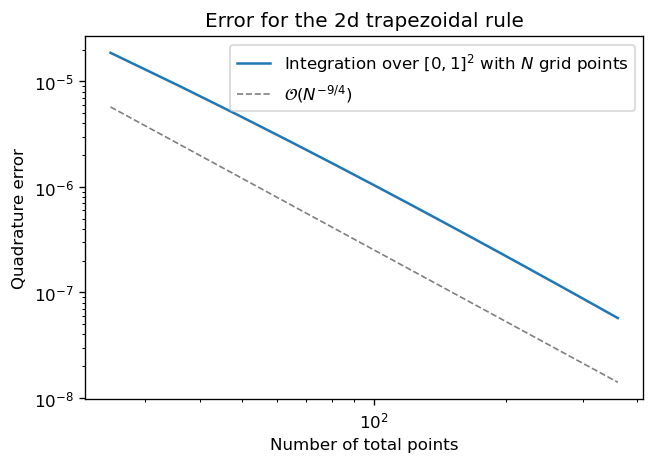

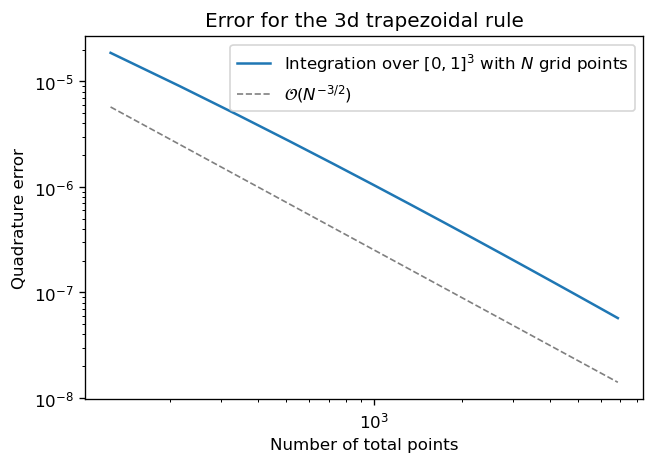

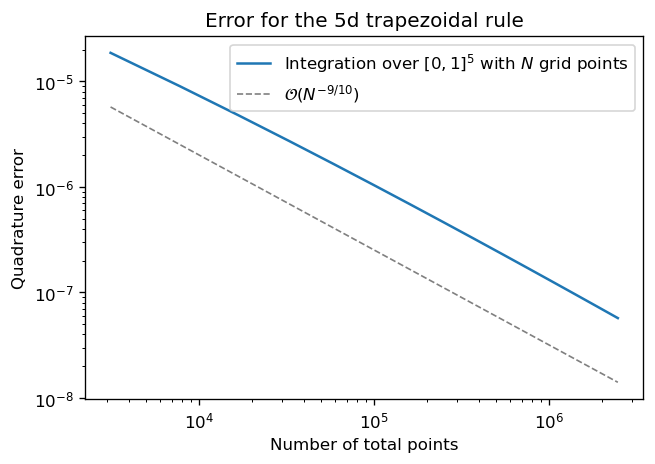

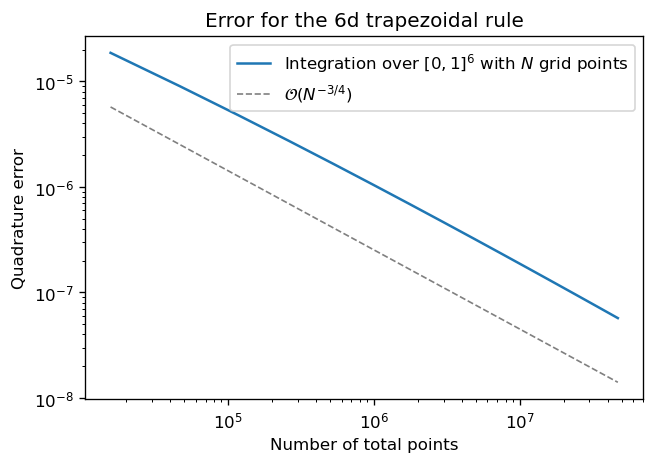

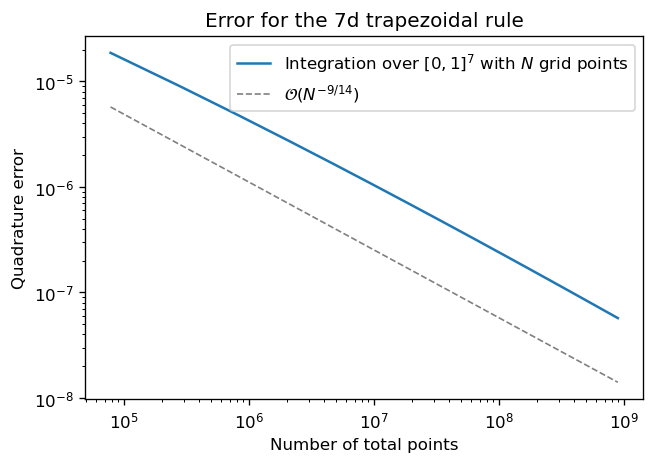

In [8]:
dimensions = [2,3,5,6,7]

for dim in dimensions:
    Ns = np.arange(5,20)
    
    a = np.zeros((dim,))
    b = np.ones((dim,))
    
    res = np.array([MultiDQuadrature(gauss,f,a,b,N).integrate() for N in Ns])
    
    error = np.abs(res - 1.)
    
    plt.loglog(np.array(Ns)**dim, error, label=f"Integration over $[0,1]^{dim}$ with $N$ grid points")

    order = Fraction(9,2*dim)
    
    # Plot convergence order
    x0 = Ns[0]**dim
    x1 = Ns[-1]**dim
    y = lambda x : 0.008/x**(order)
    y0 = y(x0)
    y1 = y(x1)
    
    plt.loglog([x0,x1], [y0,y1], '--', color='gray', label=f"$\mathcal{{O}}(N^{{-{order}}})$", linewidth=1)

    plt.ylabel('Quadrature error')
    plt.xlabel('Number of total points')
    plt.title(f"Error for the {dim}d trapezoidal rule")
    plt.legend()
    plt.show();